In [1]:
pip install xgboost tensorflow pandas scikit-learn matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

2025-07-08 08:41:07.259583: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751964067.506502      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751964067.576080      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Load parquet files (Kaggle-style)
train = pd.read_parquet("/kaggle/input/unsw-nb15/UNSW_NB15_training-set.parquet")
test = pd.read_parquet("/kaggle/input/unsw-nb15/UNSW_NB15_testing-set.parquet")

# Combine and clean
df = pd.concat([train, test])
df = df.drop(columns=["id", "attack_cat"], errors="ignore")

# Factorize categorical features
for col in ['proto', 'service', 'state']:
    df[col] = pd.factorize(df[col])[0]

# Extract X, y
X = df.drop(columns=["label"])
y = df["label"]

# Standardize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [4]:
def build_encoder(input_dim):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(256)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('swish')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('swish')(x)
    projection = layers.Dense(64)(x)
    return models.Model(inputs, projection)

def contrastive_loss(query, key, queue, temperature=0.07):
    query = tf.math.l2_normalize(query, axis=1)
    key = tf.math.l2_normalize(key, axis=1)
    queue = tf.math.l2_normalize(queue, axis=1)

    l_pos = tf.reshape(tf.reduce_sum(query * key, axis=1), [-1, 1])
    l_neg = tf.matmul(query, queue, transpose_b=True)
    logits = tf.concat([l_pos, l_neg], axis=1) / temperature
    labels = tf.zeros(logits.shape[0], dtype=tf.int32)
    return tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels, logits))

def augment_tabular(X, mask_prob=0.15, noise_std=0.05):
    mask = (np.random.rand(*X.shape) > mask_prob).astype(np.float32)
    noise = np.random.normal(0, noise_std, size=X.shape).astype(np.float32)
    return X * mask + noise

@tf.function
def momentum_update(query_encoder, key_encoder, m=0.999):
    for q, k in zip(query_encoder.trainable_variables, key_encoder.trainable_variables):
        k.assign(m * k + (1 - m) * q)

class MoCoQueue:
    def __init__(self, dim=64, size=8192):
        self.queue = tf.Variable(tf.random.normal([size, dim]), trainable=False)
        self.queue.assign(tf.math.l2_normalize(self.queue, axis=1))
        self.ptr = tf.Variable(0, trainable=False, dtype=tf.int32)
        self.size = size

    @tf.function
    def enqueue(self, keys):
        batch_size = tf.shape(keys)[0]
        idx = tf.range(self.ptr, self.ptr + batch_size) % self.size
        self.queue.scatter_nd_update(tf.expand_dims(idx, 1), keys)
        self.ptr.assign((self.ptr + batch_size) % self.size)

    def get(self):
        return self.queue

In [5]:
def run_moco_xgboost(X, y, ratios, epochs=20, batch_size=512):
    results = []

    combo_id = 1  # For Combo numbering like "Combo 2"

    for train_pct, test_pct in ratios:
        print(f"\n🔁 Combo {combo_id} → Train:Test = {train_pct}:{test_pct}")
        X_train, X_test, y_train, y_test = train_test_split(
            X.astype(np.float32), y,
            test_size=test_pct / 100, stratify=y, random_state=42
        )

        encoder = build_encoder(X_train.shape[1])
        key_encoder = build_encoder(X_train.shape[1])
        for q, k in zip(encoder.variables, key_encoder.variables):
            k.assign(q)

        optimizer = tf.keras.optimizers.Adam(3e-4)
        queue = MoCoQueue()

        last_loss = 0
        last_report = {}

        for epoch in range(epochs):
            idx = np.random.permutation(X_train.shape[0])
            X_shuffle = X_train[idx]

            for i in range(0, len(X_shuffle), batch_size):
                batch = X_shuffle[i:i + batch_size]
                if batch.shape[0] < 2: continue
                x_q = augment_tabular(batch)
                x_k = augment_tabular(batch)

                with tf.GradientTape() as tape:
                    z_q = encoder(x_q, training=True)
                    z_k = key_encoder(x_k, training=False)
                    z_k = tf.stop_gradient(z_k)
                    loss = contrastive_loss(z_q, z_k, queue.get())

                grads = tape.gradient(loss, encoder.trainable_variables)
                optimizer.apply_gradients(zip(grads, encoder.trainable_variables))
                momentum_update(encoder, key_encoder)
                queue.enqueue(z_k)

            last_loss = float(loss.numpy())
            print(f" Epoch {epoch + 1}/{epochs}, Loss: {last_loss:.4f}")

        # Final evaluation after training
        emb_train = encoder.predict(X_train)
        emb_test = encoder.predict(X_test)

        clf = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1,
                                use_label_encoder=False, eval_metric='logloss')
        clf.fit(emb_train, y_train)
        y_pred = clf.predict(emb_test)

        last_report = classification_report(y_test, y_pred, output_dict=True)

        results.append({
            'combo': combo_id,
            'train_pct': train_pct,
            'test_pct': test_pct,
            'epoch': epochs,
            'loss': last_loss,
            'accuracy': last_report['accuracy'],
            'f1_0': last_report['0']['f1-score'],
            'f1_1': last_report['1']['f1-score']
        })

        # Final print after each combo
        print(f"{len(emb_test)}/{len(emb_test)} ━━━━━━━━━━━━━━━━━━━━ Done")
        print(f"✅ Finished Combo {combo_id}: "
              f"Accuracy={last_report['accuracy']:.4f}, "
              f"Loss={last_loss:.4f}, "
              f"F1 Class 0={last_report['0']['f1-score']:.4f}, "
              f"F1 Class 1={last_report['1']['f1-score']:.4f}")

        combo_id += 1

    return pd.DataFrame(results)


In [6]:
ratios = [(10, 90),(20, 80) ,(30, 70), (40, 60),(50, 50),(60, 40) ,(70, 30),(80, 20), (90, 10)]
results_df = run_moco_xgboost(X.values, y.values, ratios)
results_df.to_csv("moco_xgboost_results.csv", index=False)


🔁 Combo 1 → Train:Test = 10:90


I0000 00:00:1751964109.170213      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751964109.170953      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


 Epoch 1/20, Loss: 6.5917
 Epoch 2/20, Loss: 6.3770
 Epoch 3/20, Loss: 6.1260
 Epoch 4/20, Loss: 6.1350
 Epoch 5/20, Loss: 6.1229
 Epoch 6/20, Loss: 6.0002
 Epoch 7/20, Loss: 5.8851
 Epoch 8/20, Loss: 6.0232
 Epoch 9/20, Loss: 5.7406
 Epoch 10/20, Loss: 5.9659
 Epoch 11/20, Loss: 5.7446
 Epoch 12/20, Loss: 5.9650
 Epoch 13/20, Loss: 5.6461
 Epoch 14/20, Loss: 5.6790
 Epoch 15/20, Loss: 5.6441
 Epoch 16/20, Loss: 5.7525
 Epoch 17/20, Loss: 5.6987
 Epoch 18/20, Loss: 5.7497
 Epoch 19/20, Loss: 5.6892
 Epoch 20/20, Loss: 5.4899


I0000 00:00:1751964204.803419     106 service.cc:148] XLA service 0x79853401b240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751964204.804295     106 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751964204.804316     106 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751964204.902053     106 cuda_dnn.cc:529] Loaded cuDNN version 90300


115/806 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

I0000 00:00:1751964205.237565     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


806/806 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
7248/7248 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
231906/231906 ━━━━━━━━━━━━━━━━━━━━ Done
✅ Finished Combo 1: Accuracy=0.9044, Loss=5.4899, F1 Class 0=0.8609, F1 Class 1=0.9272

🔁 Combo 2 → Train:Test = 20:80
 Epoch 1/20, Loss: 6.2465
 Epoch 2/20, Loss: 6.0400
 Epoch 3/20, Loss: 5.9182
 Epoch 4/20, Loss: 5.8691
 Epoch 5/20, Loss: 5.8440
 Epoch 6/20, Loss: 5.7039
 Epoch 7/20, Loss: 5.8704
 Epoch 8/20, Loss: 5.5175
 Epoch 9/20, Loss: 5.6169
 Epoch 10/20, Loss: 5.6783
 Epoch 11/20, Loss: 5.5081
 Epoch 12/20, Loss: 5.4871
 Epoch 13/20, Loss: 5.6560
 Epoch 14/20, Loss: 5.5526
 Epoch 15/20, Loss: 5.5765
 Epoch 16/20, Loss: 5.4878
 Epoch 17/20, Loss: 5.4730
 Epoch 18/20, Loss: 5.2114
 Epoch 19/20, Loss: 5.4051
 Epoch 20/20, Loss: 5.3975
1611/1611 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
6442/6442 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
206139/206139 ━━━━━━━━━━━━━━━━━━━━ Done
✅ Finished Combo 2: Accuracy=0.9093, Loss=5.3975, F1 Class 0=0.8683, F1 Class 1=0.9309

🔁 Combo 3 → 

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

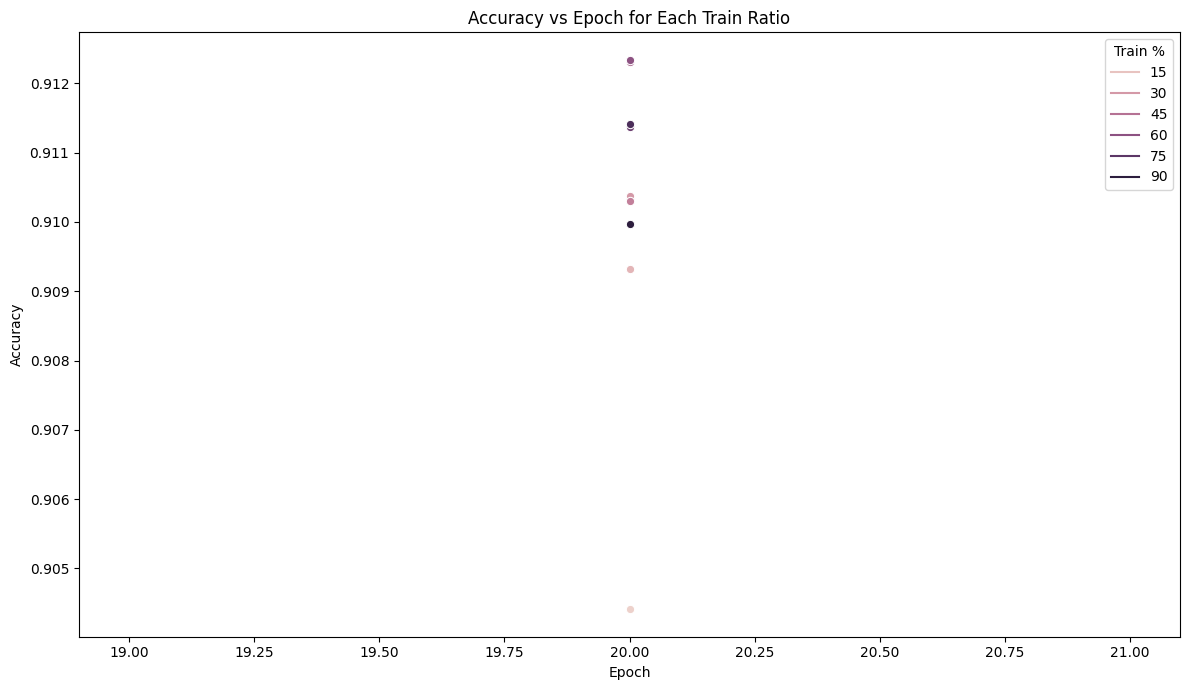

In [7]:
plt.figure(figsize=(12, 7))
sns.lineplot(data=results_df, x="epoch", y="accuracy", hue="train_pct", marker="o")
plt.title("Accuracy vs Epoch for Each Train Ratio")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(title="Train %")
plt.tight_layout()
plt.show()

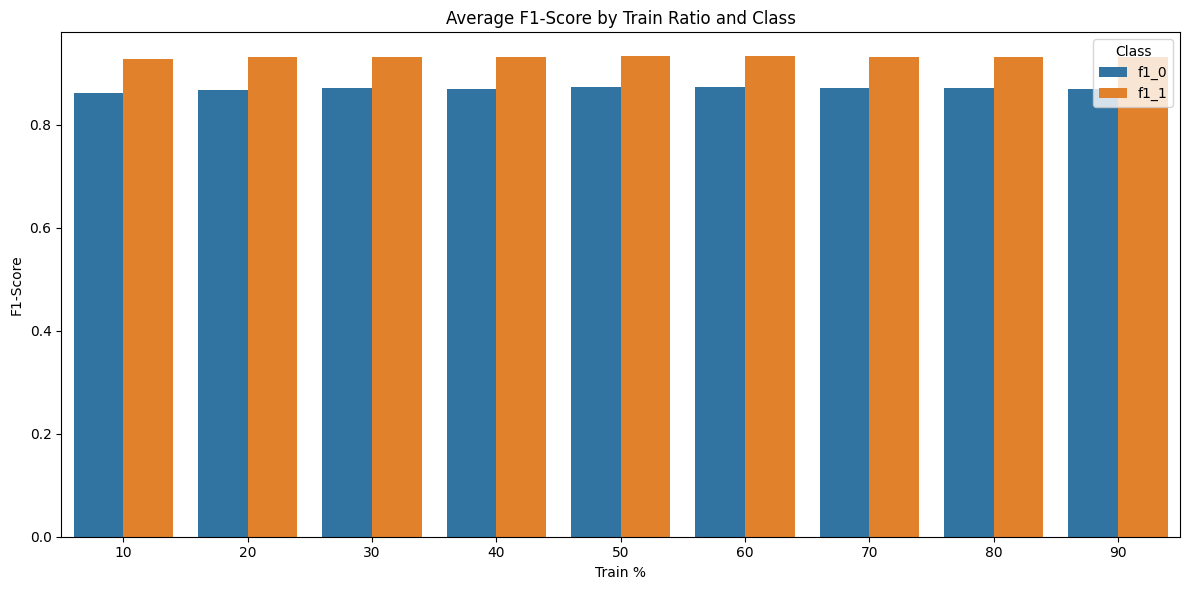

In [8]:
avg_scores = results_df.groupby("train_pct")[["f1_0", "f1_1"]].mean().reset_index()
avg_scores = pd.melt(avg_scores, id_vars="train_pct", var_name="Class", value_name="F1-Score")

plt.figure(figsize=(12, 6))
sns.barplot(data=avg_scores, x="train_pct", y="F1-Score", hue="Class")
plt.title("Average F1-Score by Train Ratio and Class")
plt.xlabel("Train %")
plt.ylabel("F1-Score")
plt.tight_layout()
plt.show()

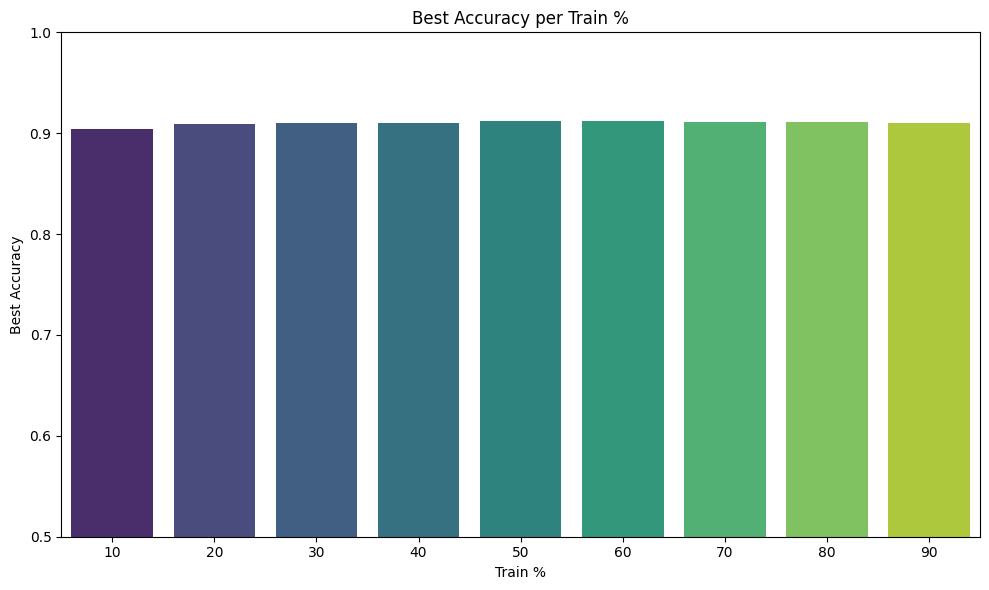

In [9]:
best_acc = results_df.groupby("train_pct")["accuracy"].max().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=best_acc, x="train_pct", y="accuracy", palette="viridis")
plt.title("Best Accuracy per Train %")
plt.xlabel("Train %")
plt.ylabel("Best Accuracy")
plt.ylim(0.5, 1.0)
plt.tight_layout()
plt.show()